Vsevolod Klyushev

In [2]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt 
import seaborn as sns
import time

%matplotlib inline
sns.set_style("whitegrid")

In [3]:
class GridWorld(object):
    
    def __init__(self):
        super(GridWorld, self).__init__()
        self.start = 0
        self.goal = 0
        
        # Provide the setting of gridWorld rows and columns
        self.row = 7
        self.col = 10
        self.x_max = self.col - 1
        self.y_max = self.row - 1

        # Declare windy columns and their effect
        self.wind_1 = [3, 4, 5, 8]
        self.wind_2 = [6, 7]
        
        # Provide action list : Up/Down/Left/Right
        self.actions_list = ['N', 'E', 'S', 'W']
      
    # here, cells defined by index
    def cell(self,pos):
        return pos[1] + self.col * pos[0]
    
    def setTerminal(self, startState, goalState):
        # startState and goalState are tuples
        self.start = self.cell(startState)
        self.goal = self.cell(goalState)
        
    def nextState(self, state, action):
        # The "state" parameter is an integer that represents position in grid
        x = state % self.col
        y = (state - x) / self.col

        # Now let's define and interpret actions
        del_x = 0
        del_y = 0
        if action == 'E':
            del_x = 1
        elif action == 'W':
            del_x = -1
        elif action == 'N':
            del_y = -1
        elif action == 'S':
            del_y = 1
        else:
            raise('Invalid action! Actions taken must be in: ', self.actions_list)

        # Now move to new position
        new_x = max(0, min(x + del_x, self.x_max))
        new_y = max(0, min(y + del_y, self.y_max))
        
        # When wind blows to a new state
        if new_x in self.wind_1:
            new_y = max(0, new_y - 1)
        if new_x in self.wind_2:
            new_y = max(0, new_y - 2)
        
        # now let's return these new state values
        return self.cell((new_y,new_x))
    
    def checkTerminal(self, state):
        return state == self.goal
    
    def rewardFunction(self, state_prime):
        # When it reaches terminal state then reward is 0 else all actions should yield -1
        if self.checkTerminal(state_prime):
            return 0
        else:
            return -1

In [4]:
def trajectoryPath(world, traj):
    # Initialize gridworld
    world_map = np.zeros((world.row, world.col))
    for i,state in enumerate(traj):
        x = int(state % world.col)
        y = int((state - x) / world.col)
        world_map[y, x] = i + 1
    print(world_map)
    print("\n")

In [5]:
# function for greedy action
def greedyAct(_q_dict):
    greedy_act = ''
    max_q = -1e10
    for act in world.actions_list:
        if _q_dict[act] > max_q:
            greedy_act = act
            max_q = _q_dict[act]
    return greedy_act

# function for epsilon-greedy action
def epsGreedy(episode, q_dict, epsilon):
    
    m = len(world.actions_list)
    greedy_act = greedyAct(q_dict)

    # strange implementation; today you will see better ones
    p = []
    for act in world.actions_list:
        if act == greedy_act:
            p.append((epsilon * 1. / m) + 1 - epsilon)
        else:
            p.append(epsilon * 1. / m)

    # choose one action given proba
    choice = np.random.choice(world.actions_list, size = 1, p = p)
    return choice[0]

In [6]:
def gridWorld_SARSA(world, startState, goalState, alpha=0.1, gamma=1, epsilon=0.1):
    # Consider input parameters:
    # gamma = 1 as discounted factor
    # default values of alpha and epsilon considered, it will be changed for multiple analysis
    world.setTerminal(startState, goalState)
    
    # Initialize Q(s,a)
    q_table = {}
    for state in range(world.row * world.col):
        q_table[state] = {}
        for act in world.actions_list:
            q_table[state][act] = 0
    
    ep = 1 # Episode number
    ep_max = 101 # number of max episodes
    step_ep_list = []
    step = 0

    # strange implementation
    while ep < ep_max:

        # Initialize state
        state = world.cell(startState)
        trajectory = [state]
        
        # Choose action from state
        act = epsGreedy(ep, q_table[state], epsilon)

        # Processing action
        while not world.checkTerminal(state):
            state_prime = world.nextState(state, act)
            reward = world.rewardFunction(state_prime)
            act_prime = epsGreedy(ep, q_table[state_prime], epsilon)
            # what's wrong with it?
            q_table[state][act] += alpha * (reward + gamma * q_table[state_prime][act_prime] - q_table[state][act])
            state = state_prime
            act = act_prime

            # Increase Step Counter
            step += 1
            
            # Store the index of the episode of this time step
            step_ep_list.append(ep)
            
            # Update the trajectory
            trajectory.append(state)
        
        if ep == (ep_max - 1):
            trajectoryPath(world, trajectory)
        # Increase the episode counter
        ep += 1
    
    start_time = time.time()
    plt.plot(step_ep_list)
    print("Time elapsed is (in Secs): ", time.time() - start_time)
    plt.title('WindyGridWorld_SARSA ', fontsize = 'large')
    plt.xlabel("Number of Steps taken")
    plt.ylabel("Number of Episodes")
    plt.show()

In [7]:
def gridWorld_SARSA_Labda(world, startState, goalState, alpha=0.1, gamma=1, epsilon=0.1, lambd=0.9, plot = False):
    # Consider input parameters:
    # gamma = 1 as discounted factor
    # default values of alpha and epsilon considered, it will be changed for multiple analysis
    world.setTerminal(startState, goalState)
    
    # Initialize Q(s,a)
    q_table = {}
    for state in range(world.row * world.col):
        q_table[state] = {}
        for act in world.actions_list:
            q_table[state][act] = 0

    e_traces = {}
    for state in range(world.row * world.col):
        e_traces[state] = {}
        for act in world.actions_list:
            e_traces[state][act] = 0
    
    ep = 1 # Episode number
    ep_max = 101 # number of max episodes
    step_ep_list = []
    step = 0

    # strange implementation
    while ep < ep_max:

        # Initialize state
        state = world.cell(startState)
        trajectory = [state]
        
        # Choose action from state
        act = epsGreedy(ep, q_table[state], epsilon)

        # Processing action
        while not world.checkTerminal(state):
            state_prime = world.nextState(state, act)
            reward = world.rewardFunction(state_prime)
            act_prime = epsGreedy(ep, q_table[state_prime], epsilon)
            
            delta = reward + gamma * q_table[state_prime][act_prime] - q_table[state][act]
            e_traces[state][act] += 1

            
            for s in range(world.row * world.col):
                for a in world.actions_list:
                    q_table[s][a] += alpha * delta * e_traces[s][a]
                    e_traces[s][a] *= gamma * lambd

            state = state_prime
            act = act_prime

            # Increase Step Counter
            step += 1
            
            # Store the index of the episode of this time step
            step_ep_list.append(ep)
            
            # Update the trajectory
            trajectory.append(state)
        
        if plot:
            if ep == (ep_max - 1):
                trajectoryPath(world, trajectory)
        # Increase the episode counter
        ep += 1
    
    if plot:
        start_time = time.time()
        plt.plot(step_ep_list)
        print("Time elapsed is (in Secs): ", time.time() - start_time)
        plt.title('WindyGridWorld_SARSA ', fontsize = 'large')
        plt.xlabel("Number of Steps taken")
        plt.ylabel("Number of Episodes")
        plt.show()
        
    return len(step_ep_list)

Plot for Option: ∈=0.1, α=0.5 

[[ 7.  0.  0. 13. 14. 15. 16. 17. 18. 19.]
 [ 8.  0. 12.  0.  0.  0.  0.  0.  0. 20.]
 [ 9. 10. 11.  0.  0.  0.  0.  0.  0. 21.]
 [ 1.  0.  0.  0.  0.  0.  0. 27.  0. 22.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 23.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 26. 24.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 25.]]


Time elapsed is (in Secs):  0.012999534606933594


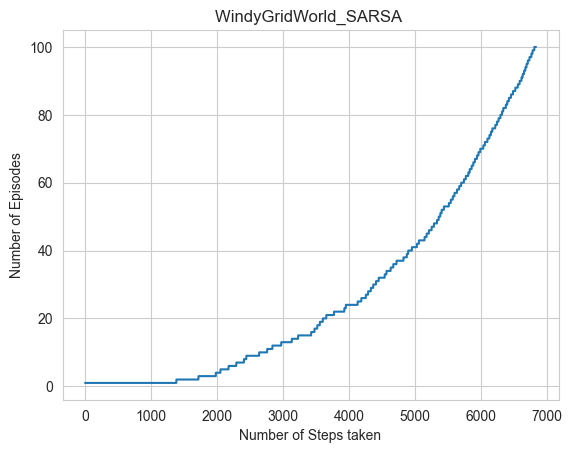

In [8]:
startState = (3, 0)
goalState = (3, 7)
world = GridWorld()
print("Plot for Option: ∈=0.1, α=0.5 \n")
gridWorld_SARSA(world, startState, goalState, alpha=0.5, epsilon=0.1)

Plot for Option: ∈=0.1, α=0.5 

[[ 0.  0.  0.  0.  0.  6.  7. 10. 11. 14.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 15.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0. 16.]
 [ 1.  2.  3.  0.  0.  0.  0. 23.  0. 17.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 18.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 22. 20.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 21.]]


Time elapsed is (in Secs):  0.011000633239746094


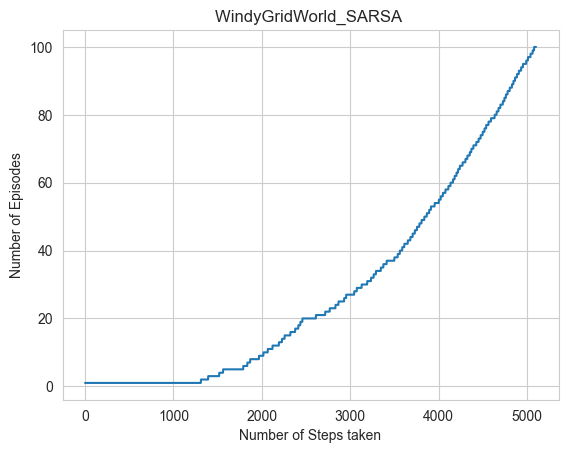

5101

In [9]:
startState = (3, 0)
goalState = (3, 7)
world = GridWorld()
print("Plot for Option: ∈=0.1, α=0.5 \n")
gridWorld_SARSA_Labda(world, startState, goalState, alpha=0.5, epsilon=0.1, lambd=0.5, plot=True)

If choose lambda 0.9 it might die.

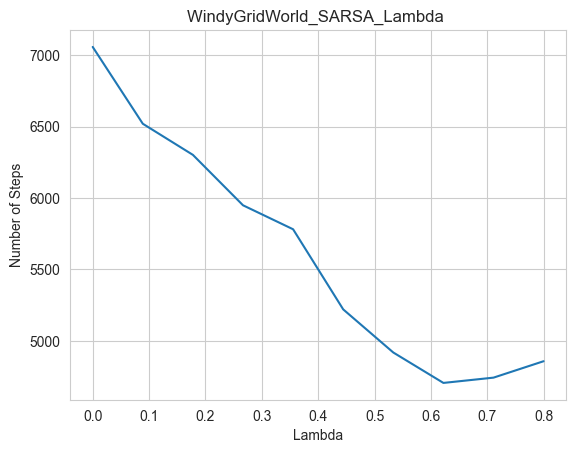

In [10]:
hist = []
for lambd in np.linspace(0, 0.8, 10):
    startState = (3, 0)
    goalState = (3, 7)
    world = GridWorld()
    temp = gridWorld_SARSA_Labda(world, startState, goalState, alpha=0.5, epsilon=0.1, lambd=lambd)
    hist.append(temp)

plt.plot(np.linspace(0, 0.8, 10),hist)
plt.title('WindyGridWorld_SARSA_Lambda ', fontsize = 'large')
plt.xlabel("Lambda")
plt.ylabel("Number of Steps")
plt.show()

As we can see with increasing of lambda number of steps decreese, however if you'll choose quite hight lambda algorithm might die in infinite loop.

Now let's do 2nd part of the task. I'll train 3 models for each pair.

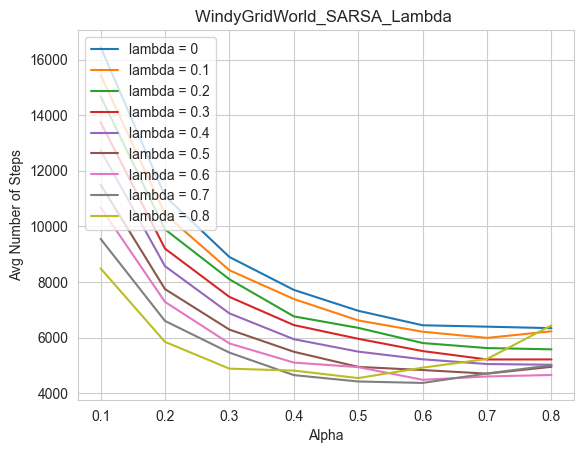

In [11]:

for lambd in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    hist = []
    for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]: #np.linspace(0.1, 0.8, 10):
        startState = (3, 0)
        goalState = (3, 7)
        temp = 0
        for i in range (3):
            world = GridWorld()
            temp += gridWorld_SARSA_Labda(world, startState, goalState, alpha=alpha, epsilon=0.1, lambd=lambd)
        temp /= 3
        hist.append(temp)
    plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], hist, label=f"lambda = {lambd}")

plt.legend(loc="upper left")
plt.title('WindyGridWorld_SARSA_Lambda ', fontsize = 'large')
plt.xlabel("Alpha")
plt.ylabel("Avg Number of Steps")
plt.show()